In [1]:
import numpy as np
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

def Combination(k, n):
    l = np.arange(1,k+1)
    L = np.copy(l)
    while l[0]<(n+1)-k:
        i=1
        while l[-i]>n-i:
            i+=1
        l[-i]+=1
        for j in range((k+1)-i,k):
            l[j]=l[j-1]+1
        L=np.vstack((L,l))
    return L

def bash_command(cmd): #bash_command(sh)
    subprocess.run(cmd, shell=True, executable='./')

In [2]:
#Pour l'instant on ne considère que la méthode rapide pour simplifier le problème

def FusionJobs(subject, k, n, draw, threads): #n = nombre de sujets considérés, k = nombre de sujets choisis parmi les n
    
    bash = open('FusionJob_'+str(k)+'sub.sh', "w")
    bash.write('#!/bin/bash\n\n')
    bash.write('\nmkdir sub-'+format(subject, '03')+'\ncd ./sub-'+format(subject, '03')+'\n')

    for i in draw: #Nombre de génération des sujets
        line = ''
        
        if k<n:
            Lsub = np.random.choice(np.delete(np.arange(1, n+1), subject-1), k, replace=False)
        else:
            Lsub = np.delete(np.arange(1, n+1), subject-1)

        out = 'sub-'+format(subject, '03')+'_'+str(k)+'sub'+'_'+str(i)+'_Labels.nii.gz'
        target = '../../../sub-'+format(subject, '03')+'/ses-1/anat/sub-'+format(subject, '03')+'_ses-1_T1map.nii.gz'
        line += '\nantsJointFusion -d 3 -o '+out+' -t '+target

        for sub in Lsub:
            if sub < subject:
                index = str(sub-1)
            else:
                index = str(sub-2)
            folder = '../../../derivatives/fusion_warpfiles/'
            warped = folder+'sub-'+format(subject, '03')+'/sub-'+format(subject, '03')+'_malf_atlas60_QUICK_sub-'+format(sub, '03')+'_ses-1_T1map_'+index+'_Warped.nii.gz'
            labels = folder+'sub-'+format(subject, '03')+'/sub-'+format(subject, '03')+'_malf_atlas60_QUICK_sub-'+format(sub, '03')+'_ses-1_T1map_'+index+'_WarpedLabels.nii.gz'
            line += ' -g '+warped+' -l '+labels

        bash.write(line)
        #bash.write(line+' -c 2 -j '+str(threads))
    
    bash.write('\n\ncd ../\n')
    bash.write('rm FusionJob_'+str(k)+'sub.sh') #burn after reading
    bash.close()

In [3]:
def MetricsJobs(subject, k, n, draw): #n = nombre de sujets considérés, k = nombre de sujets choisis parmi les n
    
    bash = open('MetricsJob_'+str(k)+'sub.sh', "w")
    bash.write('#!/bin/bash\n\n')
    bash.write('\ncd ./sub-'+format(subject, '03')+'\n')

    for i in draw: #Nombre de génération des sujets
        line = ''

        out = 'sub-'+format(subject, '03')+'_'+str(k)+'sub'+'_'+str(i)+'_Metrics'
        DGN_Labels = '../../../derivatives/atlases/sub-'+format(subject, '03')+'/ses-1/sub-'+format(subject, '03')+'_ses-1_7TAMI_DGN.nii.gz'
        Fusion_Labels = './sub-'+format(subject, '03')+'_'+str(k)+'sub'+'_'+str(i)+'_Labels.nii.gz'
        line += '\nLabelOverlapMeasures 3 '+DGN_Labels+' '+Fusion_Labels+' '+out
    
        bash.write(line)
    
    bash.write('\n\ncd ../\n')
    bash.write('rm MetricsJob_'+str(k)+'sub.sh') #burn after reading
    bash.close()

In [21]:
draw = [0,1,2]
L_subjects = np.arange(1,61)
L_n_labels = np.linspace(2, 60, 10, dtype = int)[:-1] #60 labels corespond à la segmentation malf

'''for subject in L_subjects:
    for k in L_n_labels:
        FusionJobs(subject, k, 60, draw, 32)
        subprocess.run(["bash","FusionJob_"+str(k)+"sub.sh"])
        MetricsJobs(subject, k, 60, draw)
        subprocess.run(["bash","MetricsJob_"+str(k)+"sub.sh"])'''

'for subject in L_subjects:\n    for k in L_n_labels:\n        FusionJobs(subject, k, 60, draw, 32)\n        subprocess.run(["bash","FusionJob_"+str(k)+"sub.sh"])\n        MetricsJobs(subject, k, 60, draw)\n        subprocess.run(["bash","MetricsJob_"+str(k)+"sub.sh"])'

In [22]:
atlas_7TAMI = []
atlas_7TAMI = pd.read_csv('labels.csv',sep=';')
#print (atlas_7TAMI)
#print(atlas_7TAMI.Abbrev.to_string(index=False))

my_dict = atlas_7TAMI.to_dict('dict')

#print (my_dict)
#print (atlas_7TAMI)

abbrev = atlas_7TAMI['Abbrev']
group = atlas_7TAMI['group']
fullname = atlas_7TAMI['fullname']
lat = atlas_7TAMI['lat']

df = []

for subject in L_subjects[:1]:
    for i in draw:
        for k in L_n_labels: #Pour le moment on ne récupère que les deux premiers et le dernier
            subj = pd.read_csv('./sub-'+format(subject, '03')+'/sub-'+format(subject, '03')+'_'+str(k)+'sub_'+str(i)+'_Metrics')
            subj['ID'] = subject
            subj['n_labels'] = k
            #subj['random']
            #subj['method'] = "QUICK"

            subj = subj.join(abbrev)
            subj = subj.join(group)
            subj = subj.join(fullname)
            subj = subj.join(lat)

            df.append(subj)

            '''subj = pd.read_csv('./sub-'++'sub-'++'_2sub_0_Metrics.txt')
            subj['ID'] = subject
            subj['n_labels'] = k
            #subj['random']
            #subj['method'] = "QUICK"

            subj = subj.join(abbrev)
            subj = subj.join(group)
            subj = subj.join(fullname)
            subj = subj.join(lat)

            df.append(subj)'''
    
big_frame = pd.concat(df, ignore_index=True)
print(df)

[   Label  Total/Target   Jaccard      Dice  VolumeSimilarity  FalseNegative  \
0    All      0.872831  0.731396  0.844863          0.064085       0.127169   
1      1      0.941956  0.787447  0.881086          0.129242       0.058044   
2      2      0.889663  0.727563  0.842300          0.106476       0.110337   
3      3      0.839631  0.638871  0.779648          0.142880       0.160369   
4      4      0.778325  0.447592  0.618395          0.410959       0.221675   
5      5      0.702797  0.610942  0.758491         -0.158491       0.297203   
6      6      0.852282  0.766103  0.867563         -0.035860       0.147718   
7      7      0.785773  0.619201  0.764823          0.053323       0.214227   
8      9      0.950934  0.900857  0.947843          0.006501       0.049066   
9     10      0.957126  0.706587  0.828070          0.269674       0.042874   
10    11      0.886288  0.607102  0.755524          0.295082       0.113712   
11    12      0.875124  0.635709  0.777289         

Dice    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

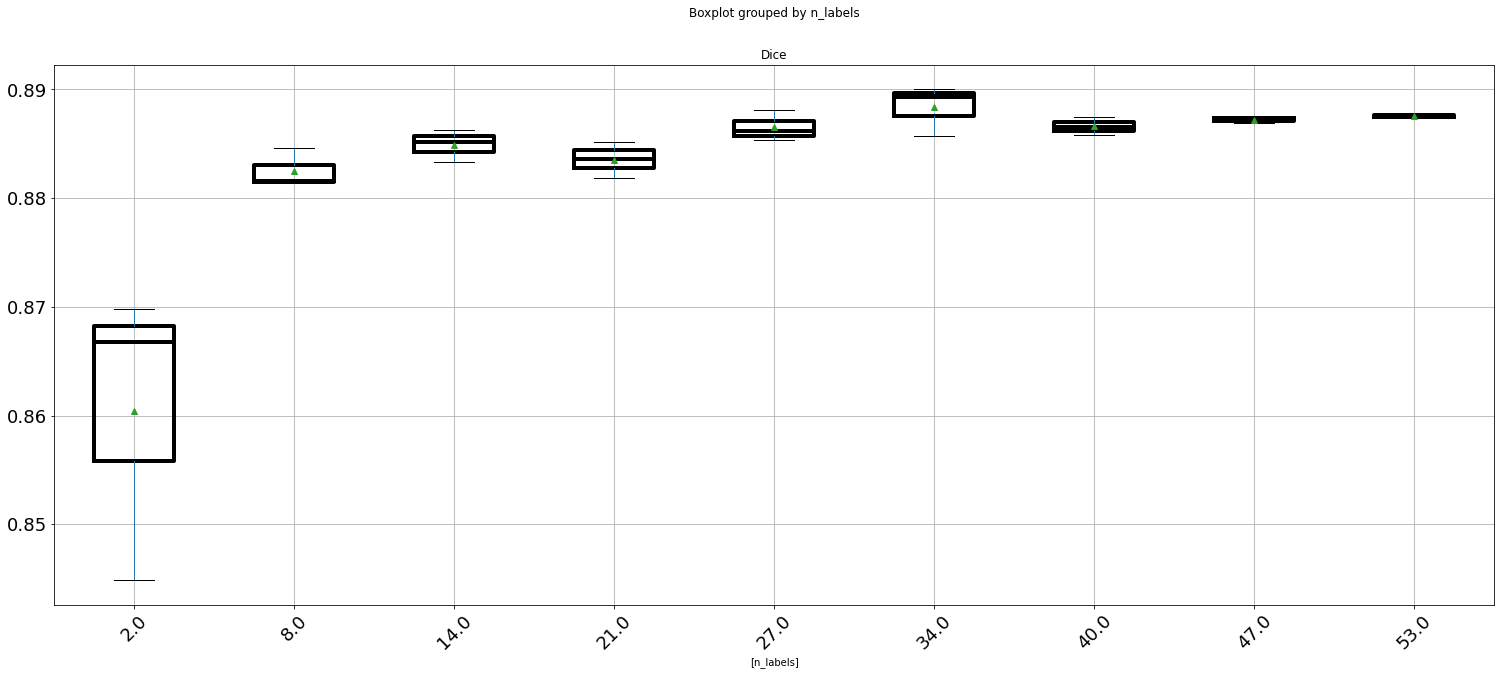

In [23]:
big_frame_cp = big_frame.copy()

'''big_frame_cp.sort_values("group", inplace = True) 
#filtering = big_frame_cp['group'] == "DGN"
filtering = big_frame_cp['group'] == "Thalamus"
big_frame_cp.where(filtering,inplace=True)
big_frame_cp = big_frame_cp.sort_values(by=['abbrev'], ascending=True)'''

filtering = big_frame_cp['Label'] == "All"
big_frame_cp.where(filtering,inplace=True)

boxprops = dict(linestyle='-', linewidth=4, color='k')
medianprops = dict(linestyle='-', linewidth=4, color='k')

big_frame_cp.boxplot(column=['Dice'], by=['n_labels'],showfliers=False, showmeans=True, boxprops=boxprops,
                medianprops=medianprops, return_type='axes', rot = 45, fontsize=18, figsize=(25,10))